# I - Data preparation

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import math
import cv2
import random
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors

In [ ]:
from sklearn.metrics import silhouette_score, accuracy_score, f1_score
from tqdm import tqdm
from sklearn.preprocessing import normalize

In [ ]:
from collections import defaultdict

In [ ]:
%%capture
!wget "https://perso.ensta-paris.fr/~manzaner/Cours/Masters_ParisSaclay/Image_Mining/CBIR_15-Scene.tgz"
!tar -xf '/content/CBIR_15-Scene.tgz'

In [ ]:
def create_train_test(data_path,class_name,train_size,test_size):
    directory = data_path + class_name + "/"
    print("Browsing directory "+directory)
    data = os.listdir(directory)
    random.shuffle(data) 
    train = data[:train_size] # take the first train_size images of each class for training
    test = data[train_size:train_size+test_size] # take the next test_size images for testing
    return train, test

class_list = []
data_path = "/content/CBIR_15-Scene/"
for file in sorted(os.listdir(data_path)):
    if os.path.isdir(data_path+file):
        class_list.append(file)        
        
train_size = 100
test_size = 100
# train_size = 30
# test_size = 10
train_set = []
test_set = []
train_set_label = []
test_set_label = []
for class_name in class_list:
    train, test = create_train_test(data_path,class_name,train_size,test_size)
    train_set = train_set + train # These are the lists of image file names
    test_set = test_set + test
    train_label = [class_name] * len(train)
    test_label = [class_name] * len(test)
    train_set_label = train_set_label + train_label # These are the lists of directory names (labels)
    test_set_label = test_set_label + test_label
print("Size of training set: ",len(train_set))
print("Size of testing set: ",len(test_set))

Browsing directory /content/CBIR_15-Scene/00/
Browsing directory /content/CBIR_15-Scene/01/
Browsing directory /content/CBIR_15-Scene/02/
Browsing directory /content/CBIR_15-Scene/03/
Browsing directory /content/CBIR_15-Scene/04/
Browsing directory /content/CBIR_15-Scene/05/
Browsing directory /content/CBIR_15-Scene/06/
Browsing directory /content/CBIR_15-Scene/07/
Browsing directory /content/CBIR_15-Scene/08/
Browsing directory /content/CBIR_15-Scene/09/
Browsing directory /content/CBIR_15-Scene/10/
Browsing directory /content/CBIR_15-Scene/11/
Browsing directory /content/CBIR_15-Scene/12/
Browsing directory /content/CBIR_15-Scene/13/
Browsing directory /content/CBIR_15-Scene/14/
Size of training set:  1500
Size of testing set:  1500


# II - Computing local descriptors on training set

100%|██████████| 1500/1500 [00:05<00:00, 274.15it/s]


Number of descriptors:  248393
Dimension of descriptors:  32
Type of descriptors:  uint8
Average computation time per image: 3.65 ms


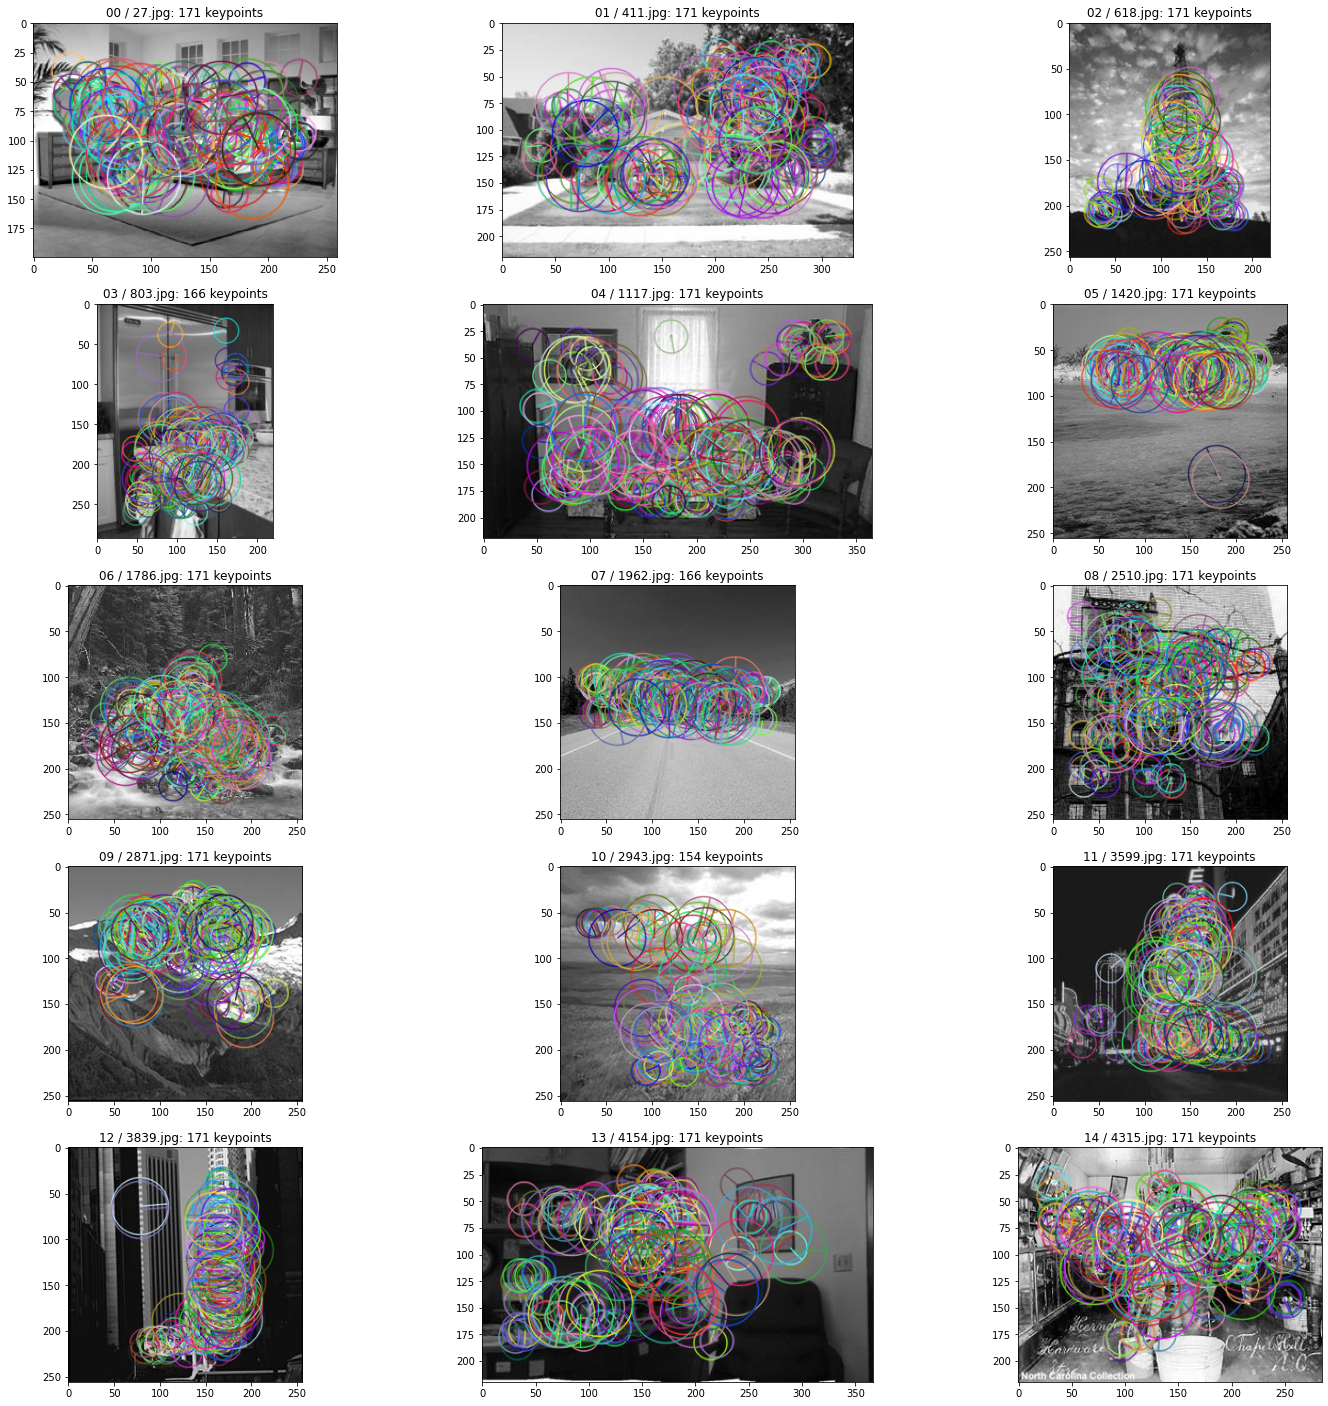

In [ ]:
train_desc_dict = defaultdict(list)
# Choose the keypoint method
method = "orb"
if (method == "kaze"):
    kp = cv2.KAZE_create(upright = False,#By default : false 
                         threshold = 0.001,#By default : 0.001
                         nOctaves = 4,#By default : 4
                         nOctaveLayers = 4,#By default : 4
                         diffusivity = 2)#By default : 2
elif (method == "orb"):  
    kp = cv2.ORB_create(nfeatures = 200,#By default : 500
                        scaleFactor = 2,#By default : 1.2
                        nlevels = 3)#By default : 8
f, disp_array = plt.subplots(5,3,figsize=(25,25))
old_label = "FIRST"
[lig, col] = [0,0]
t1 = cv2.getTickCount() #OpenCV method for estimating computation time
for i in tqdm(range(len(train_set))):
    img_file = data_path + train_set_label[i] + "/" + train_set[i]
    img = cv2.imread(img_file)
    #print("Dimension of image",img.shape[0],"rows x",img.shape[1],"columns")
    #print("Type of image:",img.dtype)
    pts, desc = kp.detectAndCompute(img, mask=None)
    if (old_label == "FIRST"):
        descriptors_dataset = desc
    else:
        descriptors_dataset = np.vstack((descriptors_dataset,desc))
    train_desc_dict[img_file] = [desc, train_set_label[i]]
    img_disp = cv2.drawKeypoints(img, pts, None, flags=4)
    if (train_set_label[i] != old_label): # Display keypoints as examples for first image of each class
        old_label = train_set_label[i]
        disp_array[lig,col].imshow(img_disp)
        nb_kp = str(desc.shape[0]) # Number of keypoints in one image
        disp_array[lig,col].title.set_text(train_set_label[i] + " / " + train_set[i] + ": " + nb_kp + " keypoints")
        col = col + 1
        if (col == 3):
            [lig,col] = [lig+1,0]
t2 = cv2.getTickCount()
time = (t2 - t1)/ cv2.getTickFrequency()
print("Number of descriptors: ",descriptors_dataset.shape[0])
print("Dimension of descriptors: ",descriptors_dataset.shape[1])
print("Type of descriptors: ",descriptors_dataset.dtype)
print("Average computation time per image:",round((1000*time)/len(train_set),2),"ms")

ORB algorithm is a blend of
modified FAST (Features from Accelerated Segment Test) detection and direction-normalized BRIEF (Binary Robust Independent Elementary Features) description methods. FAST corners are detected in each layer of the scale pyramid and cornerness of detected points is evaluated using Harris Corner score to filter out top quality points.

KAZE features in 2012 that exploit non-linear scale space through non-linear diffusion filtering [15]. This makes blurring in images locally adaptive to feature-points, thus reducing noise and simultaneously retaining the boundaries of regions in subject images. KAZE detector is based on scale normalized determinant of Hessian Matrix which is computed at multiple scale levels. The maxima of detector response are picked up as feature-points using a moving window. Feature description introduces the property of rotation invariance by finding dominant orientation in a circular neighborhood around each detected feature. KAZE features are invariant to rotation, scale, limited affine and have more distinctiveness at varying scales with the cost of moderate increase in computational time. Equation (3) shows the standard nonlinear diffusion formula.

**Comparison**
ORB is the most efficient feature-detector-descriptor with least computational cost. It is seen through this experiment that ORB computes the detectors and descriptors faster than KAZE. Although ORB also has a low feature matching time, KAZE has a relatively lower feature matching time than ORB.

# III - Dictionary creation (here K-Means Clustering)

The elbow method runs k-means clustering on the dataset for a range of values which is from 10 to 300 with 20 steps. Then for each value computes an average score for all clusters. By default, the sum of square distances from each point to its assigned center is computed. We then select the elbow point in the curve that shows the distortion values. Other metrics can also be used such as the silhouette score, the mean silhouette coefficient for all samples. Below you can see a curve which shows the sum of squared errors and silhouette score. I selected 230 clusters which is the point that minimizes both the sum of squared erros and the silhouette score.

In [ ]:
l_sil, l_in = [], []
h = 300
for k in tqdm(range(10, 300, 20)):
  kmeans = KMeans(n_clusters = k, init = 'random').fit(descriptors_dataset)
  kmeans_prediction = kmeans.predict(descriptors_dataset)
  silhouette_avg_ = silhouette_score(descriptors_dataset, kmeans_prediction)
  l_sil.append(silhouette_avg_)
  l_in.append(kmeans.inertia_)

100%|██████████| 15/15 [5:10:08<00:00, 1240.55s/it]


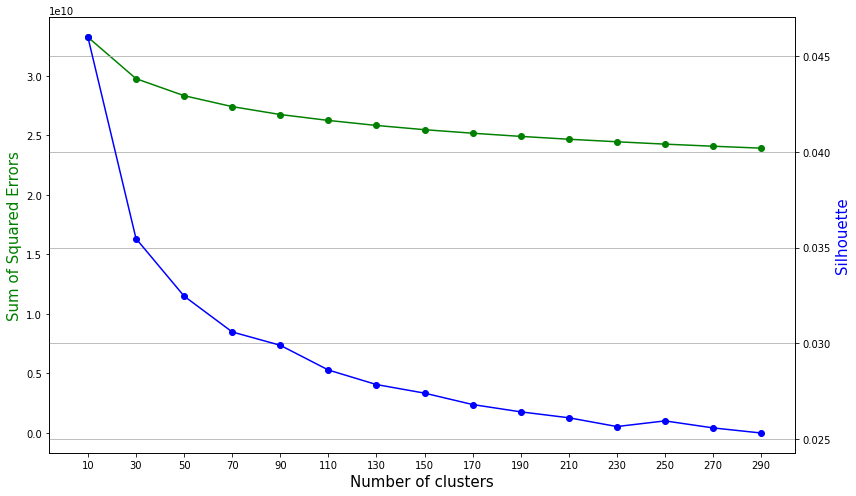

In [ ]:
fig, ax1 = plt.subplots(figsize=(12,7))
X = range(10, 300, 20)

ax1.set_xlabel('Number of clusters', fontsize=15)
ax1.set_ylabel('Sum of Squared Errors', fontsize=15, color='green')
ax1.plot(X, l_in, color='green', marker='o')
ax1.plot([8,8],[0,790], linestyle='dashed', color='red')
ax1.set_xticks(X)

ax2 = ax1.twinx()
ax2.set_ylabel('Silhouette', fontsize=15, color='blue')
ax2.plot(X, l_sil, color='blue', marker='o')

plt.grid()
#plt.title('K Means number of clusters optimization', fontsize=15)
fig.tight_layout()  
plt.show()

Here I have selected 230 words to create the codebook. This means that we will have 230 generalized descriptors. Descriptors for new images will pass throught the kmeans model to match them with their closest center in the kmeans cluster.

In [ ]:
Number_words = 230
t1 = cv2.getTickCount()
kmeans = KMeans(n_clusters = Number_words,init = 'random').fit(descriptors_dataset)
t2 = cv2.getTickCount()
cluster_time = (t2 - t1)/ cv2.getTickFrequency()
print("Size of the array of cluster centres:",kmeans.cluster_centers_.shape)
print("Size of the vector of labels:",kmeans.labels_.size)
print("Computation time of clustering:",round(cluster_time,3),"s")

Size of the array of cluster centres: (230, 32)
Size of the vector of labels: 248393
Computation time of clustering: 568.014 s



# IV - Indexing the Test Data Set (To be completed)

In [ ]:
def createHist(desc, kmeans):
  pred = kmeans.predict(desc)
  hist = np.zeros(kmeans.cluster_centers_.shape[0])
  for p in pred:
    hist[p] += 1
  return hist

In [ ]:
codebook = defaultdict(list)

def createCodebook(kmeans, dataset):
  for k,v in dataset.items():
    codebook[k] = [normalize([createHist(v[0], kmeans)])[0], v[1]]

createCodebook(kmeans, train_desc_dict)

In [ ]:
test_histograms = defaultdict(list)
test_histograms_normalized = defaultdict(list)
preds = []
for i in tqdm(range(len(test_set))):
    img_file = data_path + test_set_label[i] + "/" + test_set[i]
    img = cv2.imread(img_file)
    #print("Dimension of image",img.shape[0],"rows x",img.shape[1],"columns")
    #print("Type of image:",img.dtype)
    pts, desc = kp.detectAndCompute(img, mask=None)
    preds.append(kmeans.predict(desc))
    test_histograms[img_file] = [createHist(desc, kmeans), test_set_label[i]]
    test_histograms_normalized[img_file] = [normalize([createHist(desc, kmeans)])[0], test_set_label[i]]
    # pred.append(kmeans.predict(desc))

100%|██████████| 1500/1500 [00:06<00:00, 228.05it/s]


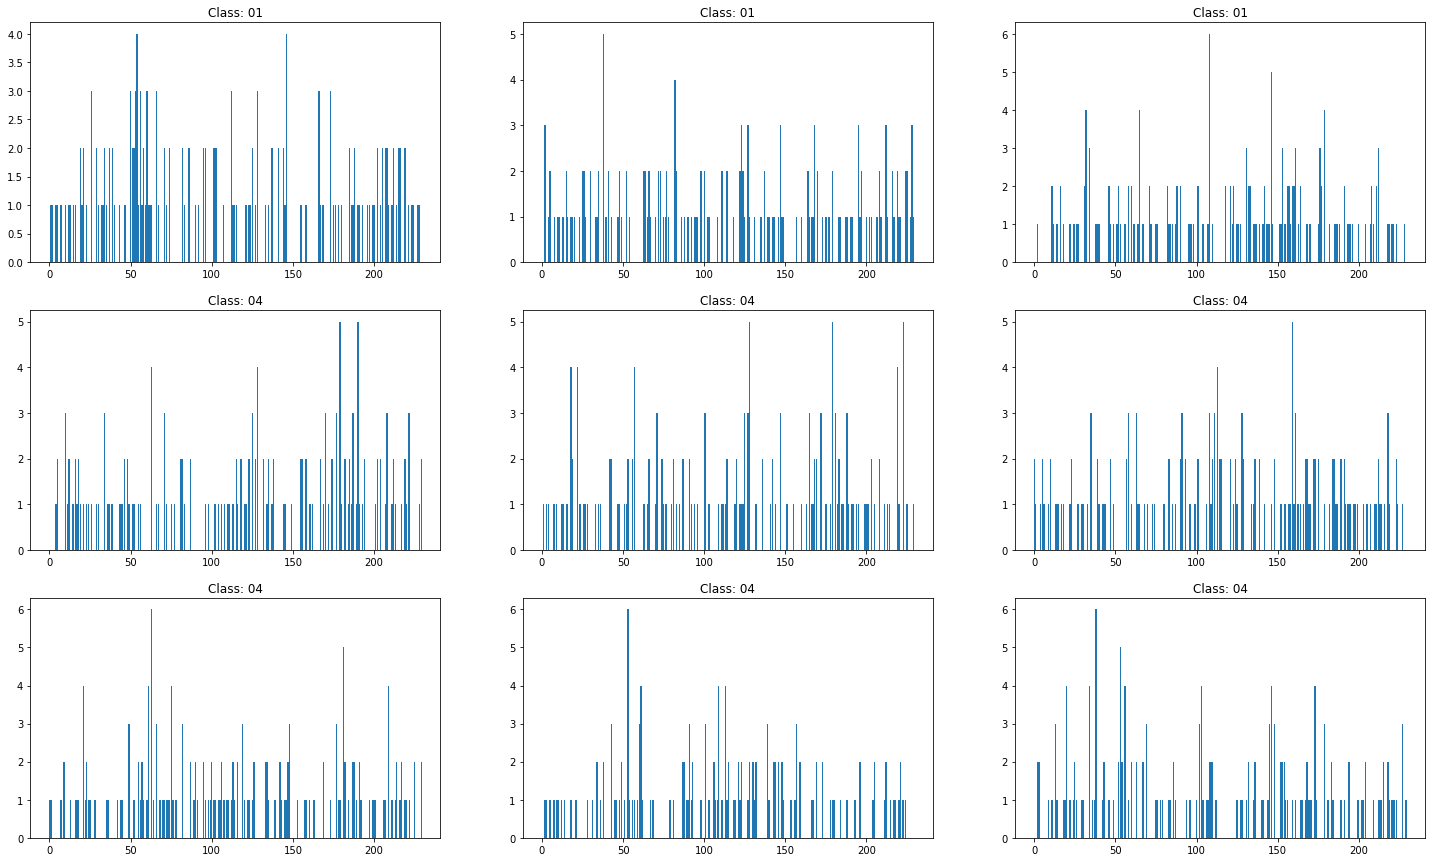

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(25,15))

for i in range(3):
  class_no = random.randint(0,14)
  for j in range(3):
    hist = list(test_histograms.items())[class_no*100 + random.randint(0,99)][1]
    hist_values = hist[0]
    hist_class = hist[1]
    axes[i,j].bar(list(range(len(hist_values))), hist_values)
    axes[i,j].set_title(f'Class: {hist_class}')

The method used to represent the global descriptor is histograms of the codebook. As shown in the previous section a codebook was built using kmeans clustering. Then the descriptors each image in the test set is matched with the codebook to represent the test images with the generalized descriptors (kmeans cluster centers). Then a histogram of these generalized descriptors is displayed. As shown above, the histogram of images in the same class is expected to have similarity.

# V - Testing CBIR on some images (To be completed)

In [ ]:
X_test = [v[0] for k,v in test_histograms_normalized.items()]
y_test = [v[1] for k,v in test_histograms_normalized.items()]

neigh = KNeighborsClassifier(n_neighbors=4, algorithm='auto', metric='cosine')
neigh.fit(X_test, y_test)

KNeighborsClassifier(metric='cosine', n_neighbors=4)

In [ ]:
def getClassNames(filename):
  f=open('/content/CBIR_15-Scene/Labels.txt',"r")
  lines=f.readlines()
  classNames = {}
  for x in lines:
      classNames[x.split(' ')[0]] = x.split(' ')[1]
  f.close()
  return classNames
classNames = getClassNames('/content/CBIR_15-Scene/Labels.txt')

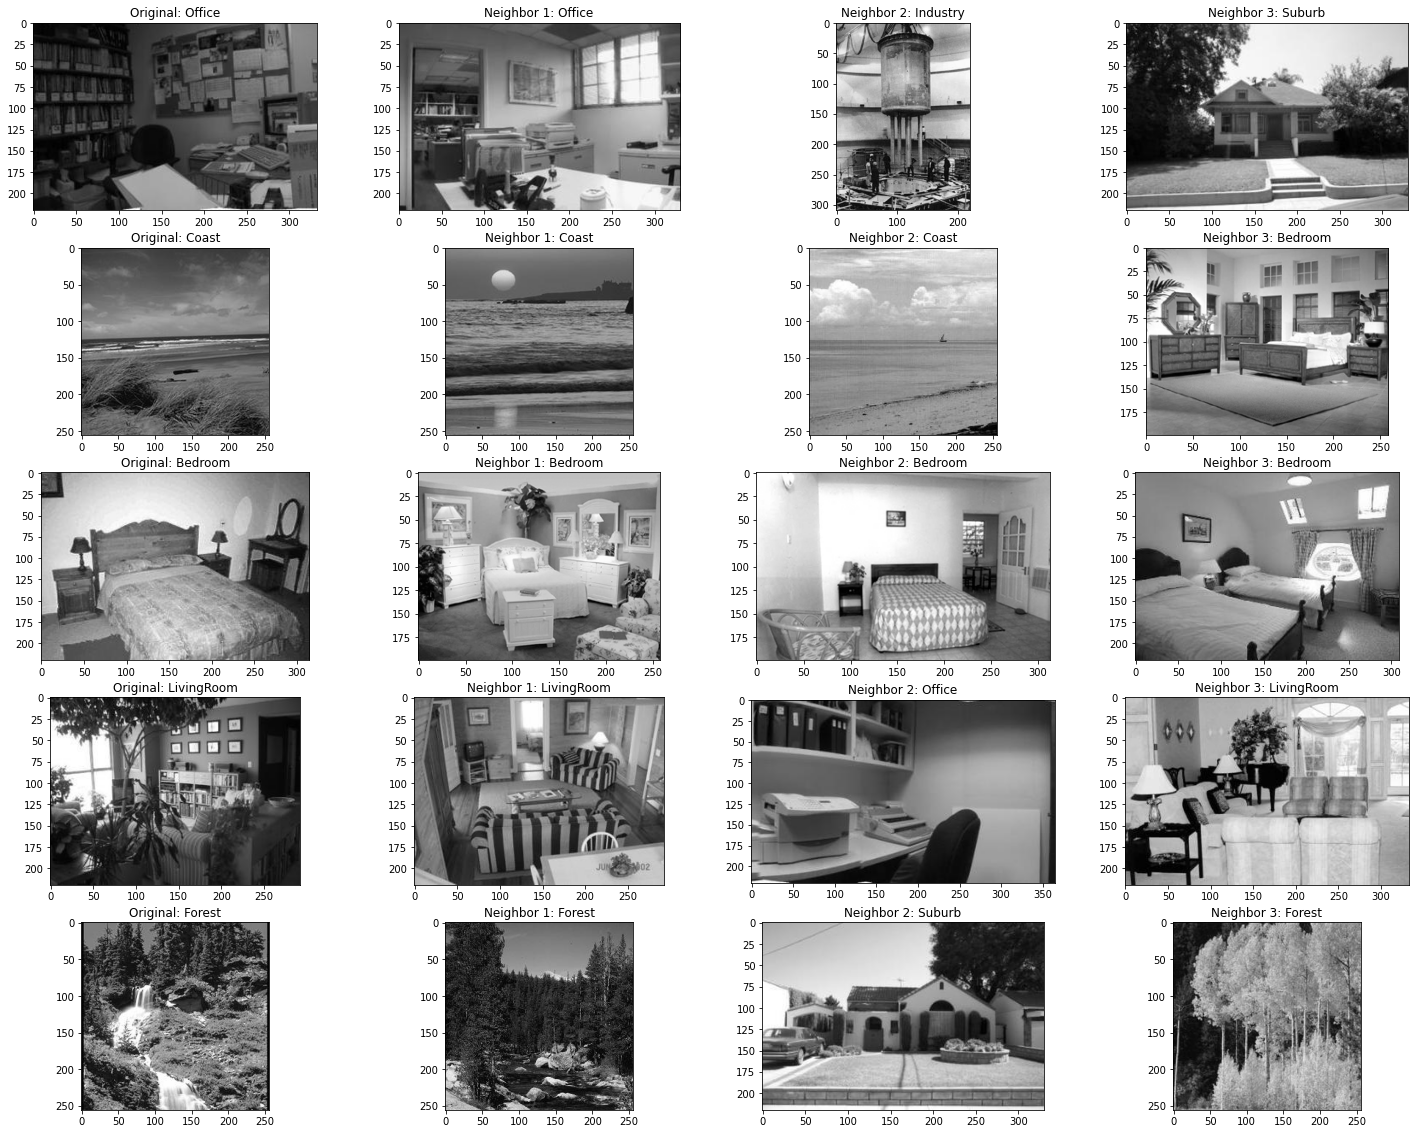

In [ ]:
no_neighbors = 3
no_examples = 5
fig, axes = plt.subplots(no_examples, no_neighbors+1, figsize=(25,20))

for i in range(no_examples):
  choice = random.choice(list(test_histograms_normalized.items()))
  X_choice, y_choice = choice[1]
  neighbors = neigh.kneighbors([X_choice])[1][0]
  
  axes[i][0].imshow(cv2.imread(choice[0]))
  axes[i][0].set_title('Original: ' + classNames[y_choice])
  for j in range(no_neighbors):
    axes[i][j+1].imshow(cv2.imread(list(codebook.items())[neighbors[j]][0]))
    # axes[i][j+1].set_title('Neighbor ' + j+1 ': ' + classNames[list(codebook.items())[neighbors[j]][1][1]])
    axes[i][j+1].set_title(f'Neighbor {j+1}: {classNames[list(codebook.items())[neighbors[j]][1][1]]}')

To match images, I built a KNN classifer using the global descriptors built in the previous section. The KNN classifier uses normalized histograms and consine similarity to train a classifier. Following that, close image matches for sample images can be found by searching for the nearest neighbors in KNN.

Above you can see matches made from the test for some sample images from the testset. As shown, there is good accuracy for most samples. Specially, the first neighbors are accurate. We can see that images from some classes have higher probability of having a perfect match with their nearest neighbors. I noticed that classes such as "Bedroom" and "Highway" have perfect matches with thier neighbors.

Below, we can see the accuracy of the prediction using the KNN on the test set which is not very good. Hence, this demands use of modern image processing tools such as convolutional neural networks.

In [ ]:
y_pred = neigh.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

0.4146666666666667